In [ ]:
 import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

100%|██████████| 331M/331M [00:03<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
BASE_DIR = '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace'
age_labels = []
image_paths = []

# List all files in the directory
image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)

    # Split the filename into components
    img_components = image.split('_')

    try:
        # Ensure the filename has the correct format
        if len(img_components) < 2:
            raise ValueError(f"Filename {image} does not match the expected format")

        # Extract age and gender labels
        age_label = int(img_components[0])


        # Append the image_path, age_label, and gender_label
        age_labels.append(age_label)
        image_paths.append(image_path)
    except ValueError as e:
        print(f"Skipping file {image}: {e}")

# Check if labels were loaded successfully
print(f"Loaded {len(age_labels)} valid images.")


  0%|          | 0/23708 [00:00<?, ?it/s]

Loaded 23708 valid images.


In [ ]:
print("Age Labels: ",age_labels[0:4])
print("Image Path: ",image_paths[0:4])

Age Labels:  [30, 26, 16, 26]
Image Path:  ['/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/30_1_0_20170103182948122.jpg.chip.jpg', '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/26_1_3_20170119193105762.jpg.chip.jpg', '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/16_0_0_20170110232038257.jpg.chip.jpg', '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/26_1_0_20170117200917775.jpg.chip.jpg']


In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of image_paths: 23708


In [ ]:
# conver the age from number to category :
  # young => 0 : 18     = 1
  # youth => 18 : 40    = 2
  # senior => 40 : 60   = 3
  # old => 60 :         = 4

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'] = image_paths, age_labels
df.head(5)

,image_path,age
0,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,30
1,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,26
2,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,16
3,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,26
4,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,60


In [ ]:
# Define a function to assign categories
def categorize_age(age):
    if 0 <= age < 18:
        return 1
    elif 18 <= age < 40:
        return 2
    elif 40 <= age < 60:
        return 3
    elif age >= 60:
        return 4
    else:
        return "unknown"  # Handle any unexpected cases

# Apply the function to create the 'target' column
df["target"] = df["age"].apply(categorize_age)

df.head()


,image_path,age,target
0,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,30,2
1,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,26,2
2,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,16,1
3,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,26,2
4,/root/.cache/kagglehub/datasets/jangedoo/utkfa...,60,4


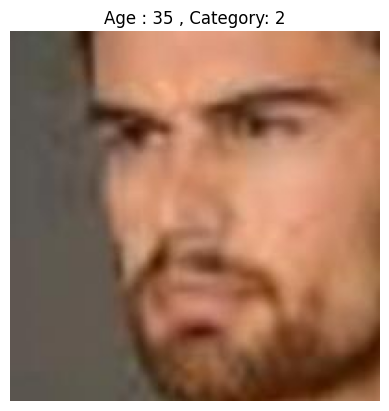

In [ ]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
target = df['target'][rand_index]
age = df['age'][rand_index]

IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age : {age} , Category: {target}' )
plt.axis('off')
plt.imshow(IMG)

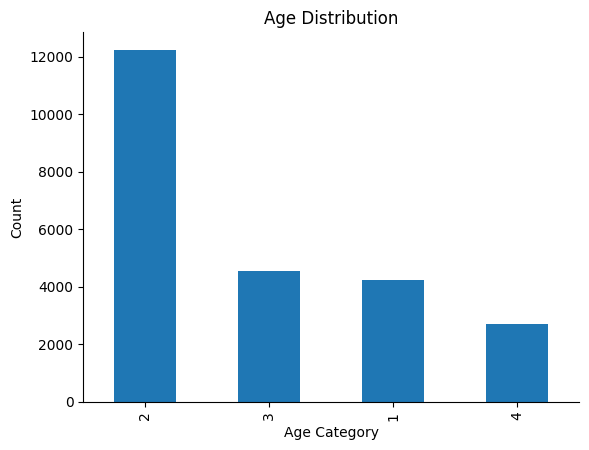

In [ ]:
age_counts = df['target'].value_counts()


# Create a bar plot instead of a histogram
age_counts.plot(kind='bar', title='Age Distribution')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

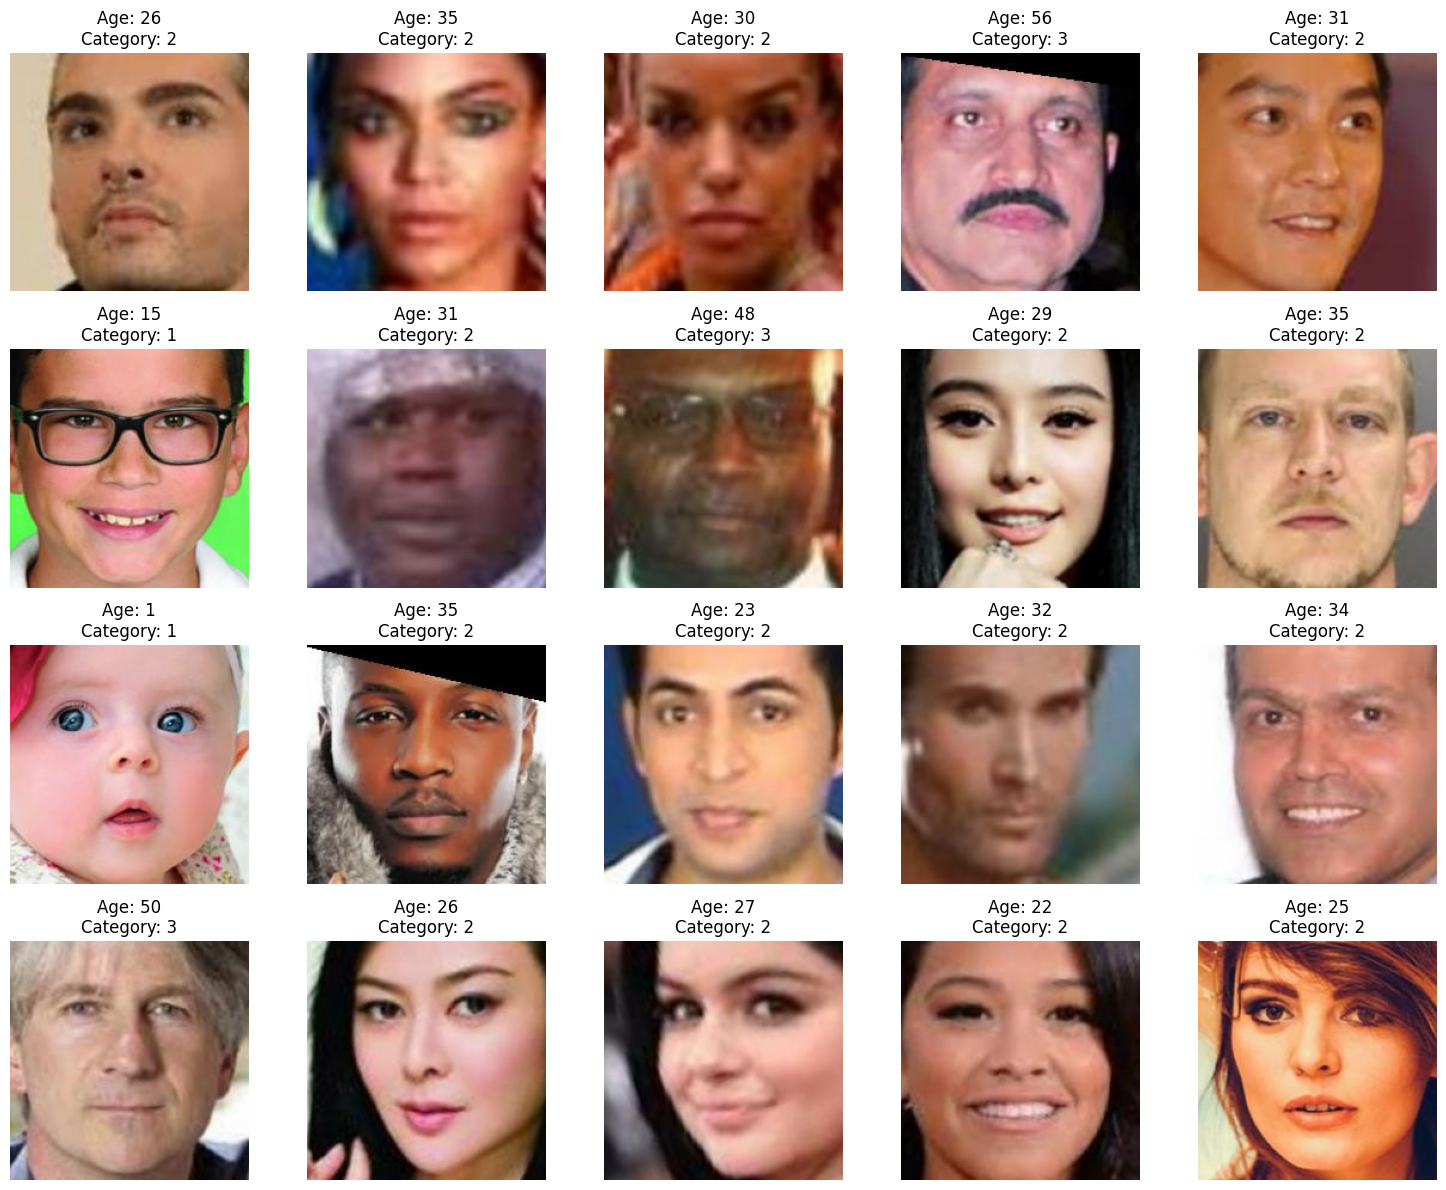

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Select 20 random samples from the DataFrame
sampled_df = df.sample(n=min(20, len(df)), random_state=42)  # Ensure it doesn't exceed the number of rows

# Display the sampled images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Create a 4x5 grid for 20 images
axes = axes.flatten()

for idx, (row, ax) in enumerate(zip(sampled_df.iterrows(), axes)):
    _, row = row
    img_path = row["image_path"]  # Get the image path from the 'image_path' column
    img = cv2.imread(img_path)  # Load the image
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        ax.imshow(img)
    else:
        ax.text(0.5, 0.5, "Image Not Found", ha='center', va='center', fontsize=12)
        ax.axis('off')

    # Set the title with age and category
    ax.set_title(f"Age: {row['age']}\nCategory: {row['target']}")  # Use 'target' instead of 'category'
    ax.axis('off')

# Hide extra axes if fewer than 20 images
for ax in axes[len(sampled_df):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Parameters
IMG_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32
NUM_CLASSES = len(df['target'].unique())  # Number of categories

print(NUM_CLASSES)

4


In [ ]:
# Function to extract features from images
from keras.preprocessing.image import load_img, img_to_array

def extract_image_features(image_paths):
    features = []
    for image_path in tqdm(image_paths, desc="Processing images"):
        try:
            # Load the image in grayscale mode
            img = load_img(image_path, color_mode='grayscale')

            # Resize the image using Resampling
            img = img.resize(IMG_SIZE, Image.Resampling.LANCZOS)

            # Convert the image to a NumPy array
            img = img_to_array(img)
            features.append(img)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    # Convert the list to a NumPy array and add an extra dimension for channels
    features = np.array(features).reshape(len(features), IMG_SIZE[0], IMG_SIZE[1], 1)
    return features

In [ ]:
# Extract features from images
X = extract_image_features(df['image_path'])


Processing images:   0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# Normalize the features
X = X / 255.0


In [ ]:
# One-hot encode the targets
# his will shift the values from the range 1-4 to 0-3, matching the expected range for one-hot encoding.

y = tf.keras.utils.to_categorical(df['target'] - 1, num_classes=NUM_CLASSES)

In [ ]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,

)
val_datagen = ImageDataGenerator()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)


# Build the CNN model

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])



# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

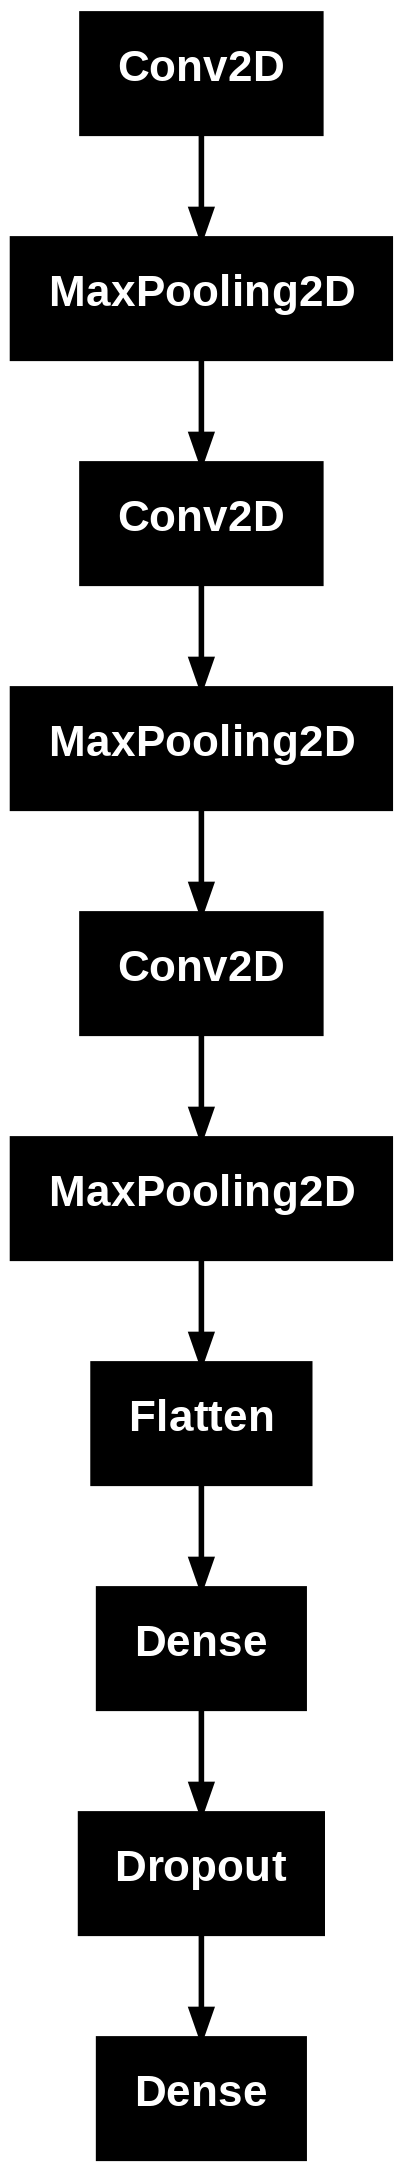

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)


In [ ]:
# Compile the model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE),
    epochs=20
)


Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.5119 - loss: 1.2079 - val_accuracy: 0.5323 - val_loss: 1.1023
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.5315 - loss: 1.1487 - val_accuracy: 0.5696 - val_loss: 1.0458
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.5490 - loss: 1.1096 - val_accuracy: 0.5917 - val_loss: 0.9849
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.5636 - loss: 1.0789 - val_accuracy: 0.5711 - val_loss: 1.0125
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.5661 - loss: 1.0695 - val_accuracy: 0.6156 - val_loss: 0.9322
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.5865 - loss: 1.0262 - val_accuracy: 0.6404 - val_loss: 0.9093
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.5887 - loss: 1.0085 - val_accuracy: 0.6284 - val_loss: 0.8879
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.6011 - loss: 0.9802 - 

In [ ]:
# Evaluate the model

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy:.2f}")


149/149 - 1s - 5ms/step - accuracy: 0.7278 - loss: 0.6894
Validation Accuracy: 0.73


In [ ]:
# model.save('age_model.h5')

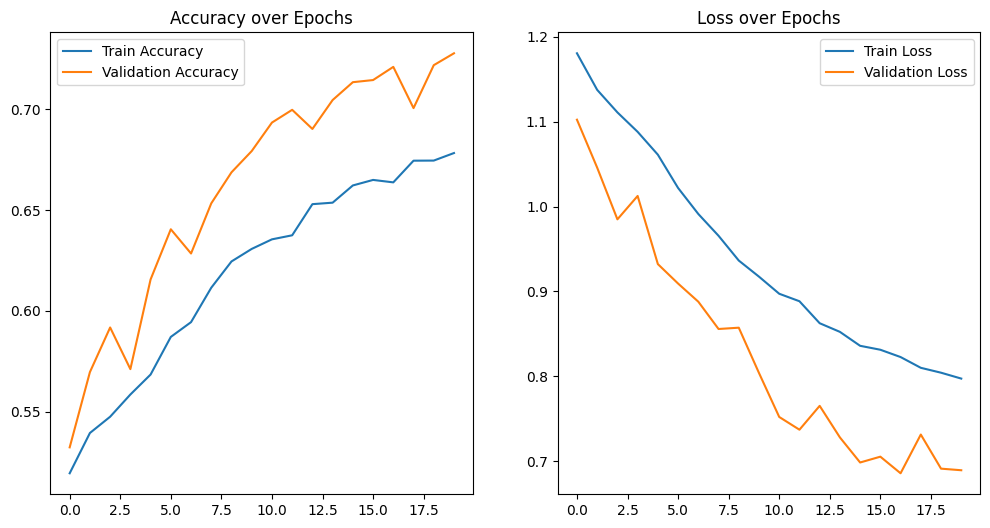

In [ ]:
# Plot accuracy and loss curves for better insight
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()